In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
import matplotlib.pyplot as plt
import numpy as np
import json
from functools import partial
class Foo: pass
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many
from IPython.html.widgets import interact
from IPython.html.widgets import SelectMultiple
config = Foo()

#config.name     = "HighAspect/HA_conductivity_1.0E-5/HA_conductivity_1.0E-5"
#config.arch_end = "alcf#dtn_mira/projects/alpha-nek/experiments/"

config.name     = "/home/maxhutch/cache/HA_conductivity_1.0E-5"
config.name2     = "/home/maxhutch/cache/Wilk_kmin_2.5"
config.arch_end = "maxhutch#edoras"

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from matplotlib import animation
from tempfile import NamedTemporaryFile
import base64

VIDEO_TAG = """<video controls>
 <source src="data:video/x-webm;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.webm') as f:
            anim.save(f.name, fps=6, extra_args=['-vcodec', 'libvpx', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode("utf-8")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.core.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [3]:
c = Chest(path      = "{:s}-results".format(config.name),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end),
          available_memory = 1e12)
sc = CachedSlict(c)
with glopen(
            "{:s}.json".format(config.name), mode='r',
            endpoint = config.arch_end,
            ) as f:
    params = json.load(f)

In [4]:
wc = Chest(path      = "{:s}-results".format(config.name2),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end),
          available_memory = 1e12)
wsc = CachedSlict(wc)
with glopen(
            "{:s}.json".format(config.name2), mode='r',
            endpoint = config.arch_end,
            ) as f:
    wparams = json.load(f)

In [5]:
#c.prefetch(list(c.keys()))

In [6]:
def plot_T(frame, zoom):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    fig = plt.figure()
    nx = frame['t_yz'].shape[0]; ny = frame['t_yz'].shape[1]

    expanded = np.concatenate((frame['t_yz'], np.flipud(frame['t_yz'])), axis=0)

    plt.imshow(expanded[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    plt.title("Scalar @ t = {:f}".format(T));
    

def plot_TWV(frame, zoom):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    #fig, axs = plt.subplots(1,3,sharey=True)
    nx = frame['t_yz'].shape[0]; ny = frame['t_yz'].shape[1]

    expanded_T = np.concatenate((frame['t_yz'], np.flipud(frame['t_yz'])), axis=0)
    expanded_W = np.concatenate((frame['w_yz'], np.flipud(frame['w_yz'])), axis=0)
    expanded_V = np.concatenate((frame['vorticity_yz'], -np.flipud(frame['vorticity_yz'])), axis=0)

    axs[0].imshow(expanded_T[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    axs[0].set_title("T @ t = {:f}".format(T));
    axs[1].imshow(expanded_W[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    axs[1].set_title("W @ t = {:f}".format(T));
    axs[2].imshow(expanded_V[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    axs[2].set_title("Vorticity @ t = {:f}".format(T));
    
def plot_TWV_span(frame):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    #fig, axs = plt.subplots(2,2,figsize=(16,8))
    nx = frame['t_xy'].shape[0]; ny = frame['t_xy'].shape[1]

    expanded_T = np.concatenate((frame['t_xy'], np.flipud(frame['t_xy']), frame['t_xy'], np.flipud(frame['t_xy'])), axis=0)
    expanded_T = np.concatenate((expanded_T, np.fliplr(expanded_T)), axis=1)
    
    expanded_W = np.concatenate((frame['w_xy'], np.flipud(frame['w_xy']), frame['w_xy'], np.flipud(frame['w_xy'])), axis=0)
    expanded_W = np.concatenate((expanded_W, np.fliplr(expanded_W)), axis=1)
    
    expanded_V = np.concatenate((frame['vorticity_xy'], -np.flipud(frame['vorticity_xy']), frame['vorticity_xy'], -np.flipud(frame['vorticity_xy'])), axis=0)
    expanded_V = np.concatenate((expanded_V, -np.fliplr(expanded_V)), axis=1)
    
    axs[0][0].imshow(expanded_T.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][0].set_title("T @ t = {:f}".format(T));
    axs[0][1].imshow(expanded_W.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][1].set_title("W @ t = {:f}".format(T));
    axs[1][0].imshow(expanded_V.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[1][0].set_title("Vorticity @ t = {:f}".format(T));

def plot_TWVP_span(frame):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    #fig, axs = plt.subplots(2,2,figsize=(16,8))
    nx = frame['t_xy'].shape[0]; ny = frame['t_xy'].shape[1]

    expanded_T = np.concatenate((frame['t_xy'], np.flipud(frame['t_xy']), frame['t_xy'], np.flipud(frame['t_xy'])), axis=0)
    expanded_T = np.concatenate((expanded_T, np.fliplr(expanded_T)), axis=1)
    
    expanded_W = np.concatenate((frame['w_xy'], np.flipud(frame['w_xy']), frame['w_xy'], np.flipud(frame['w_xy'])), axis=0)
    expanded_W = np.concatenate((expanded_W, np.fliplr(expanded_W)), axis=1)
    
    expanded_V = np.concatenate((frame['vorticity_xy'], -np.flipud(frame['vorticity_xy']), frame['vorticity_xy'], -np.flipud(frame['vorticity_xy'])), axis=0)
    expanded_V = np.concatenate((expanded_V, -np.fliplr(expanded_V)), axis=1)
    
    expanded_P = np.concatenate((frame['p_xy'], np.flipud(frame['p_xy']), frame['p_xy'], np.flipud(frame['p_xy'])), axis=0)
    expanded_P = np.concatenate((expanded_P, np.fliplr(expanded_P)), axis=1)
    axs[0][0].imshow(expanded_T.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][0].set_title("T @ t = {:f}".format(T));
    axs[0][1].imshow(expanded_W.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][1].set_title("W @ t = {:f}".format(T));
    axs[1][0].imshow(expanded_V.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[1][0].set_title("Vorticity @ t = {:f}".format(T));
    axs[1][1].imshow(expanded_P.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[1][1].set_title("Pressure @ t = {:f}".format(T));
    
def plot_wilk_span(frame):
    T = wsc[:,'frame'].keys()[frame]
    frame = wsc[T,:]
    #fig, axs = plt.subplots(2,2,figsize=(16,12))
    nx = frame['t_xy'].shape[0]; ny = frame['t_xy'].shape[1]

    expanded_T = frame['t_xy']
    expanded_W = frame['w_xy']
    expanded_V = frame['vorticity_xy']
    expanded_P = frame['p_xy']

    axs[0][0].imshow(expanded_T.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[0][0].set_title("T @ t = {:f}".format(T));
    axs[0][1].imshow(expanded_W.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[0][1].set_title("W @ t = {:f}".format(T));
    axs[1][0].imshow(expanded_V.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[1][0].set_title("Vorticity @ t = {:f}".format(T));
    axs[1][1].imshow(expanded_P.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[1][1].set_title("Pressure @ t = {:f}".format(T));

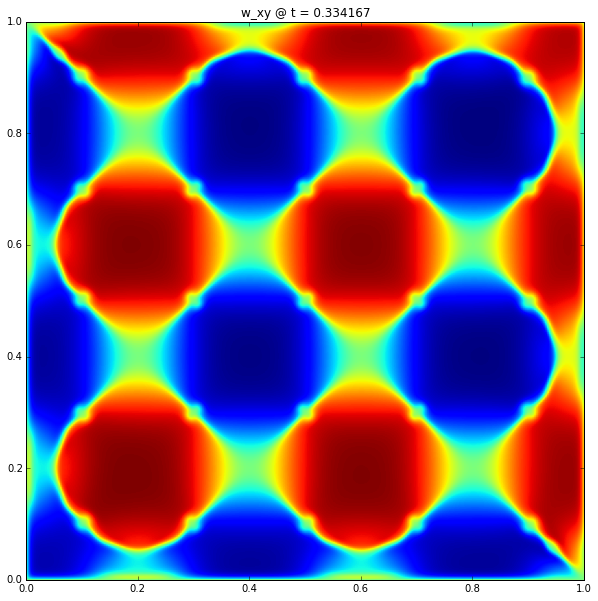

In [7]:
def plot_wilk_span_multi(frame, fields):
    T = wsc[:,'frame'].keys()[frame]
    frame = wsc[T,:]
    nrow = int(len(fields) / 3 + .9)
    if nrow < 2:
        fig, axs = plt.subplots(nrow,len(fields))
    else:
        fig, axs = plt.subplots(nrow,3)
    nx = frame['t_xy'].shape[0]; ny = frame['t_xy'].shape[1]

    row = 0; col = 0
    for field in fields:
        data = frame[field]
        if nrow > 1:
            ax = axs[row][col]
        elif len(fields) > 1:
            ax = axs[col]            
        else:
            ax = axs
        ax.imshow(data.transpose(), origin='lower', extent=[0,1,0,1]);
        ax.set_title("{:s} @ t = {:f}".format(field, T));            

        col = col + 1
        if col == 3:
            row = row + 1
            col = 0
    
w = SelectMultiple(
    description="Fields",
    options=['t_xy', 'vorticity_xy', 'p_xy', 'w_xy', 'u_xy', 'v_xy', ]);
interact(plot_wilk_span_multi, frame=(0,20), fields=w);

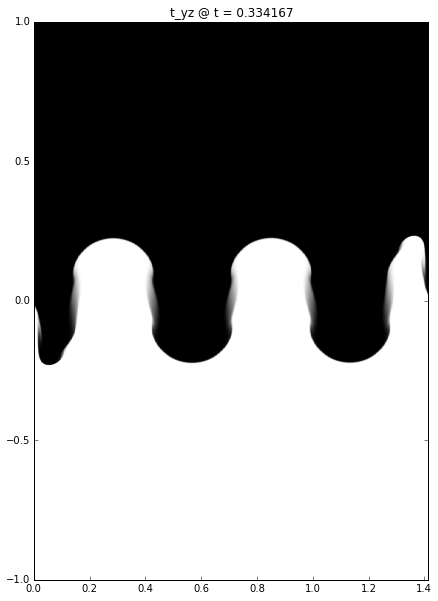

In [8]:
def plot_wilk_multi(frame, fields):
    T = wsc[:,'frame'].keys()[frame]
    frame = wsc[T,:]
    nrow = int(len(fields) / 3 + .9)
    if nrow < 2:
        fig, axs = plt.subplots(nrow,len(fields))
    else:
        fig, axs = plt.subplots(nrow,3)
    nx = frame['t_yz'].shape[0]; ny = frame['t_yz'].shape[1]

    row = 0; col = 0
    for field in fields:
        data = frame[field]
        if nrow > 1:
            ax = axs[row][col]
        elif len(fields) > 1:
            ax = axs[col]            
        else:
            ax = axs
        ax.imshow(-data.transpose(),
                  cmap='binary',
                               origin='lower', extent=[0,np.sqrt(2),-1,1]);
        ax.set_title("{:s} @ t = {:f}".format(field, T));            

        col = col + 1
        if col == 3:
            row = row + 1
            col = 0
    
w = SelectMultiple(
    description="Fields",
    options=['t_yz', 'p_yz', 'w_yz', 'd_yz', ]);
interact(plot_wilk_multi, frame=(0,20), fields=w);

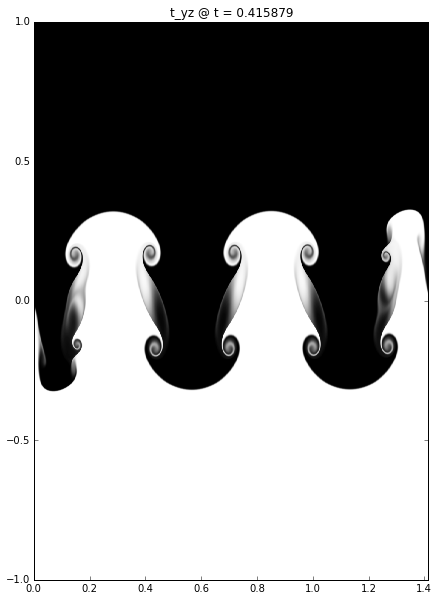

In [9]:
plot_wilk_multi(frame=20, fields=['t_yz'])
plt.savefig('t_yz_time_416.tiff')

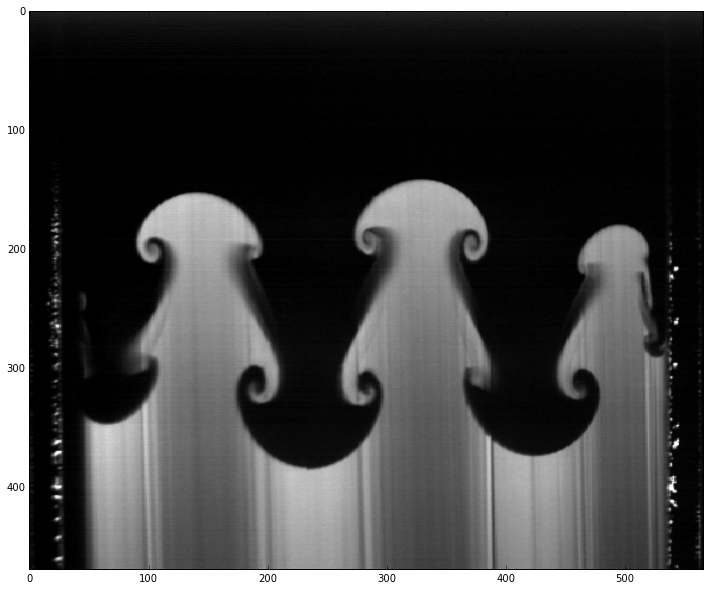

In [10]:
from PIL import Image
T = T = wsc[:,'frame'].keys()[-1]
im = Image.open('waves_2.5_time_380.tif')
dat = np.array(im)
plt.imshow(dat)

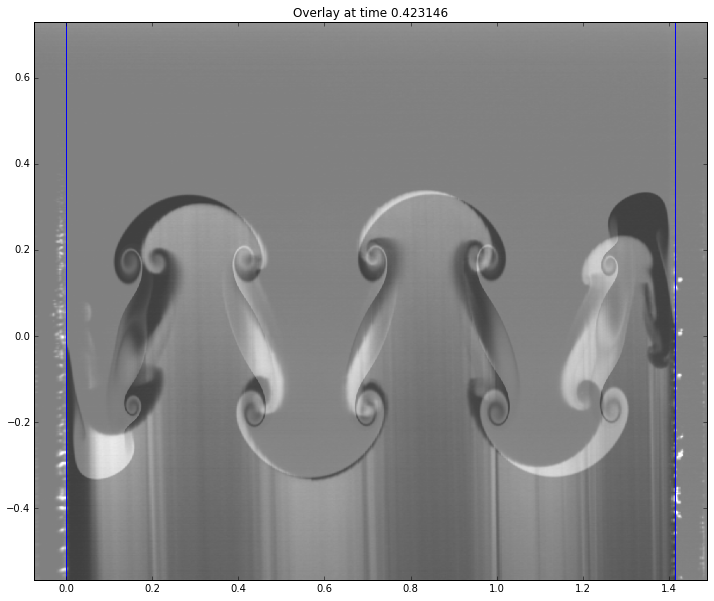

In [11]:
from PIL import Image
T = T = wsc[:,'frame'].keys()[-1]
im = Image.open('waves_2.5_time_380.tif')
dat = np.array(im)
aspect = float(dat.shape[1])/dat.shape[0]
width = np.sqrt(2)+.15
shift_x = -.075
shift_y = 0.082
height = width/aspect
plt.axvline(x=0)
plt.axvline(x=np.sqrt(2))
scale_x = 1
if True:
    plt.imshow(wc[T, 't_yz'].transpose(), 
               alpha=.5,
               extent=[np.sqrt(2)/2-scale_x*np.sqrt(2)/2,
                       np.sqrt(2)/2+scale_x*np.sqrt(2)/2,-1,1],
               cmap='binary',
               origin='lower',
              )
if True:
    plt.imshow(dat, 
               alpha=.5,
               extent=[shift_x,           shift_x + width,
                       shift_y - height/2,shift_y + height/2],
              )
plt.title("Overlay at time {:f}".format(T))
plt.savefig('WJ_overlay.tiff')

In [12]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py 
%load_ext version_information 
%version_information numpy, matplotlib, slict, chest, glopen, globussh

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.4.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.1
numpy 1.10.0.dev0+00f4fae
matplotlib 1.4.3
slict 0.2.5
chest 0.2.2
glopen 0.0.12
globussh 0.1.1
Fri Aug 14 10:04:57 2015 CDT